In [1]:
from fastai.text import * 

In [2]:
from ulmfit_experiments import experiments
from ulmfit_experiments import sentencepiece_tok as spm

# TODO: at each epoch re-generate tokens with some randomness?
# TODO: pre-tokenize, mark case, join before SP?
# TODO: try SGD instead of Adam, experiment with bigger batches

In [3]:
unsup_path = '/home/tomasz/nlp/poleval/csv/unsup.csv'

In [4]:
model_dir='/home/tomasz/nlp/poleval/csv/spm'
csv_dir = Path('/home/tomasz/nlp/poleval/csv/')

In [17]:
bs = 40

In [5]:
spm.train_tokenizer(unsup_path, model_dir)

In [6]:
tok, vocab = spm.load_tokenizer(model_dir)

In [7]:
vocab.itos[:10]

['<unk>',
 'xxbos',
 'xxpad',
 '@anonymized_account',
 '@url',
 'ie',
 '▁n',
 '▁p',
 '▁t',
 '▁s']

In [11]:
df = pd.read_csv(unsup_path, names=['labels', 'texts'], engine='python')
df = df.loc[df.texts.notnull()]

In [12]:
val_split = int(len(df)*0.9)

In [13]:
trn_df = df.iloc[:val_split]
val_df = df.iloc[val_split:]

In [36]:
# tok.process_all([trn_df.iloc[1, 1]])

In [18]:
data_lm = TextLMDataBunch.from_df(path=csv_dir, train_df=trn_df, valid_df=val_df, bs=bs, text_cols='texts', tokenizer = tok, vocab=vocab)

In [19]:
data_lm.show_batch()

idx,text
0,"▁spać ▁ale ▁mi ▁się ▁chce ▁O ▁K ▁E ▁J ▁ xxbos ▁Na ▁razie ▁tempo ▁mocno ▁waka cyjne . ▁Roma ▁na ▁sto jaka . ▁Halo ▁TT , ▁ktoś ▁wytrzymał ▁do ▁przerwy ? ▁😅 # Ro ma PS G ▁# I CC 2017 ▁ xxbos ▁Nienawidzę ▁kiedy ▁ktoś ▁chra pie . ▁Jeszcze ▁jak ▁zacznie ▁tak ▁głośno ▁to ▁kurwicy ▁dostaję ▁ xxbos ▁ @anonymized_account ▁ @anonymized_account ▁Wiadomo ▁o ▁co ▁im ▁chodzilo , ▁o"
1,"▁osobami , ▁love ▁it ▁ xxbos ▁ @anonymized_account ▁wiem , ▁szanuje ▁to , ▁że ▁np . ▁ktoś ▁woli ▁słuchać ▁np . ▁tylko ▁Nialla ▁i ▁nie ▁musi ▁podobać ▁mu ▁się ▁reszta ▁ xxbos ▁ @anonymized_account ▁Powinni ▁!! ▁ xxbos ▁sk ryty kowa l * ▁+ to ▁je szcz w ▁obraz il ▁takiego ▁o ana , ▁kto ey ▁byl ▁umie s niony , ▁dojrze , ▁ze ▁najebany ▁w ▁3 ▁du o y"
2,"▁jedzenia ▁i ▁raczej ▁nie ▁moge ▁jeść ▁juz ▁tak ▁tłu stych ▁potra w ▁ xxbos ▁ @anonymized_account ▁Mi ▁nawet ▁się ▁nie ▁opłaca ▁jeździć ▁do ▁przyjaciółki ▁bez ▁noc owania . ▁Ki lom etry ▁s są ▁ xxbos ▁Panowie , ▁ja ▁rozumiem ▁przegry wać , ▁ale ▁żeby ▁3:1 2 ? ▁ xxbos ▁I ▁nie ▁do puszcza lam ▁myśli ▁że ▁ona ▁jednak ▁nie ▁przyjedzie ▁ xxbos ▁Ale ▁United ▁z ▁Manchester u ▁ma ▁chuj owych"
3,"▁nocy ▁ xxbos ▁ @anonymized_account ▁ @anonymized_account ▁to ▁z ▁innej ▁strony ▁zapytam ▁- ▁uważasz , ▁że ▁Lech ▁zagrał ▁dobrą ▁drugą ▁połowę ? ▁ xxbos ▁ @anonymized_account ▁nikt ▁go ▁nie ▁urodził ▁znaleźli ▁go ▁w ▁kapu ście ▁ xxbos ▁dajcie ▁mi ▁jakieś ▁fajne ▁ff ▁z ▁piłkarz ami ▁🙏 ▁# fan fi ction ▁ xxbos ▁Sta raj ▁się ▁być ▁dobrym ▁człowiekiem . ▁Znaczy ▁możesz ▁czasem ▁komuś ▁pod kra ść ▁kawałek ▁pizzy . ▁Ale"
4,"▁z ▁tej ▁strony ▁na ▁to ▁patrzą . ▁ xxbos ▁gdzie ▁moj ▁okres ▁ xxbos ▁2 ▁godziny ▁26 ▁minut ▁ xxbos ▁"" My śli wi ▁w ▁Polsce ▁uch wali li ▁sobie ▁prawo , ▁które ▁pozwala ▁im ▁bezkarnie ▁mor dować ▁li sie ▁dzieci ."" ▁Moje ▁pytanie ▁brzmi : ▁po ▁chuj ? ▁ xxbos ▁Podobno ▁Paweł ▁nawet ▁nagrał ▁do ▁v loga ▁moment , ▁jak ▁pod pisuje ▁mi ▁zdjęcie , ▁aww ▁💞 ▁ xxbos"


In [32]:
one_batch_x = next(iter(data_lm.train_dl))[0].cpu()

In [35]:
for line in one_batch_x[:3]:
    print('|'.join([vocab.itos[x] for x in line]))
    print('\n')

▁ustaw|kach|▁nadal|▁wie|rzymy|▁oo|ps|▁|xxbos|▁Szuka|łam|▁jakiś|▁fajnych|▁ff|▁na|▁wattpadzie|▁ale|▁wszystkie|▁są|▁podobne|▁do|▁siebie|▁i|▁chyba|▁zacznę|▁czytać|▁od|▁nowa|▁moje|▁ulubione|▁ff|▁XD|▁XD|▁|xxbos|▁Chciałabym|▁kiedyś|▁zobaczyć|▁To|k|yo|...|▁|xxbos|▁Ba|dzona|▁|xxbos|▁Chcę|▁być|▁chłop|cem|▁|xxbos|▁Ho|ra|▁T|in|kie|-|W|in|kie|▁|xxbos|▁|@anonymized_account|▁|@anonymized_account|▁Jak


▁Jak|▁ja|▁bym|▁miała|▁pisać|▁ff|▁na|▁wattpadzie|▁to|▁byłby|▁to|▁kabaret|▁nad|▁kabaret|ami|▁|xxbos|▁Kopacz|▁mówi|,|▁że|▁już|▁nie|▁będzie|▁odpowiadać|▁na|▁pytania|▁o|▁#|S|mo|len|sk|▁bo|▁jej|▁się|▁nie|▁chce|.|▁Racja|.|▁Pora|▁skończyć|▁rozmowy|.|▁Czas|▁na|▁Trybunał|▁Stanu|.|▁|xxbos|▁|@anonymized_account|▁Real|ly|▁ja|▁może|▁jak|▁pojadę|▁to|▁tez|▁wezmę|▁ale|▁jest|▁promocja|▁na|▁necie|▁|xxbos


c|▁ze|▁chodzi|▁mi|▁o|▁ruska|▁|xxbos|▁ciekawe|▁jak|▁to|▁jest|▁nie|▁mieć|▁peł|nego|▁chino|li|▁tl|▁|xxbos|▁Chyba|▁sie|▁przet|re|nowa|lam|😥|▁|xxbos|▁|@anonymized_account|▁nadal|▁czekam|▁na|▁coś|▁lepszego|▁i|▁chyba|▁się|▁ni

In [37]:
PAD_TOKEN_ID = vocab.stoi[PAD]

In [39]:
config = {
    'type': 'Poleval1',
    'params': {
        'dataset_path': '/home/tomasz/nlp/poleval/csv/',
        'encoder_subdir': 'encoder_wiki_orig',
        'training_phases': [],
        'aggregation_class': 'SimpleAttention',
        'aggregation_params': {},
        'calc_test_score': True,
        'cv_fold_num': 0,
        'drop_mult': 1.,
#         'train_set_fraction': 0.01,
        'rnn_output_layers': [-1],
        'bidir': False,
        'max_len': 70*20,
        'bs': 80,
        'metrics': ['accuracy', 'f1']
    }
}

In [40]:
ex = experiments.ExperimentCls.factory(config['type'], config['params'])

In [50]:
# dfs = ex.get_dfs()

In [49]:
# data_cls = TextClasDataBunch.from_df(csv_dir/'cls', *dfs, tokenizer=tok, vocab=vocab, bs=40, text_cols=[1])

In [48]:
# data_cls.show_batch(10)

In [51]:
trn_args = dict(tie_weights=True, clip=ex.clip, bptt=ex.bptt,
                alpha=ex.rnn_alpha, beta=ex.rnn_beta)
learn = language_model_learner(data_lm, emb_sz=ex.emb_sz, nh=ex.nh, nl=ex.nl, pad_token=PAD_TOKEN_ID,
                   bias=True, model_dir=model_dir, **trn_args)

In [52]:
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


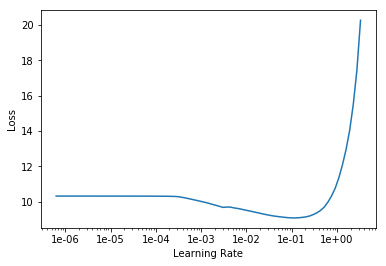

In [54]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,5.572872,5.409397,0.249831
2,5.829891,5.628707,0.241585
3,6.506228,6.274928,0.209936
4,8.761814,8.483144,0.098251
5,7.801270,7.691049,0.098251
6,7.613676,7.625049,0.098251
7,6.997140,6.846488,0.151318
8,6.934649,6.763303,0.151318
9,6.512422,6.342163,0.205876
10,6.311691,6.134712,0.212033


In [56]:
learn.save('basic_adam_10ep_5e-2')

In [57]:
learn = language_model_learner(data_lm, emb_sz=ex.emb_sz, nh=ex.nh, nl=ex.nl, pad_token=PAD_TOKEN_ID,
                   bias=True, model_dir=model_dir, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [58]:
learn.fit_one_cycle(10, 1e-2, (0.8, 0.7), wd=1e-7)

epoch,train_loss,valid_loss,accuracy
1,5.356325,5.239298,0.265918
2,5.234948,5.067109,0.275440
3,5.241044,5.041462,0.277699
4,5.170805,4.983857,0.282175
5,5.109036,4.929780,0.286854
6,5.013426,4.867586,0.291674
7,4.959431,4.808201,0.296928
8,4.873831,4.762139,0.300815
9,4.814911,4.736620,0.303149
10,4.778783,4.732564,0.303662


In [59]:
learn.save('basic_adam_ulmfit_moms_10ep_nowd_1e-2')

In [60]:
learn.save_encoder('basic_adam_ulmfit_moms_10ep_nowd_1e-2')

## using this second version, as 'encoder_tweets_spm_basic'